# Masking grid cells

This notebook will demostate the following:

  1. Basics of grid masking
  1. Reading boundary, river, and island data from shapefiles
  1. Generating a focused grid
  1. Masking land cells from the shapefiles
  1. Writing grid data to shapefiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn

import pygridgen as pgg
import pygridtools as pgt

seaborn.set(style='white')
%matplotlib inline

## Masking basics
Let's consider a simple, orthogonal $5\times5$ unit grid and a basic rectangle that we will use to mask some elements of the grid:

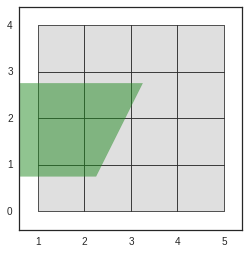

In [2]:
y, x = np.mgrid[:5, 1:6]
mg = pgt.ModelGrid(x, y)
rectangle_coords = [
    (0.25, 2.75),
    (3.25, 2.75),
    (2.25, 0.75),
    (0.25, 0.75),
]

fig, ax = plt.subplots()
fig = mg.plotCells(ax=ax)
rectangle = plt.Polygon(rectangle_coords, color='forestgreen', alpha=0.5)
ax.add_patch(rectangle)

### Applying the masks options

You have few options when applying a mask to a grid
  1. `inside=True` - by default, elements inside the polygon are masked. Setting this parameter to `False` will mask everything outside the polygon.
  1. `use_centroids=True` - The default behavior is to determine if a cell is inside or outside the polygon based on the centroid of the cell. Setting to `False` will instead count the number of nodes of each cell inside the polygon and make the determination based on the `min_nodes` parameter (continue reading)
  1. `min_nodes=3` - This parameter configures how many nodes of a cell must be inside a polygon to flag the whole cell as inside thet polygon.
  1. `use_existing=True` - When this is `True` the new mask determined from the passed polygons will be unioned (`np.bitwise_or`) with any existing mask that may be present. When this is `False` the old mask is completely overwritten with the new mask.

### Masking inside vs outside a polygon

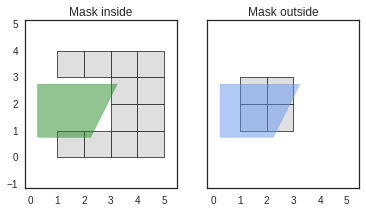

In [3]:
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)

common_opts = dict(use_centroids=True, use_existing=False)

# mask inside
mg.mask_cells_with_polygon(rectangle_coords, inside=True, **common_opts)
rect1 = plt.Polygon(rectangle_coords, color='forestgreen', alpha=0.5)
mg.plotCells(ax=ax1)
ax1.add_patch(rect1)
ax1.set_title('Mask inside')

# mask outside
mg.mask_cells_with_polygon(rectangle_coords, inside=False, **common_opts)
rect2 = plt.Polygon(rectangle_coords, color='cornflowerblue', alpha=0.5)
mg.plotCells(ax=ax2)
ax2.add_patch(rect2)
ax2.set_title("Mask outside")

### Masking with nodes instead of centroids 
This time, we'll mask with the nodes of the cells instead of the centroids. We'll show four different masks, each generated with a different minimum number of nodes requires to classify a cell as inside the polygon.

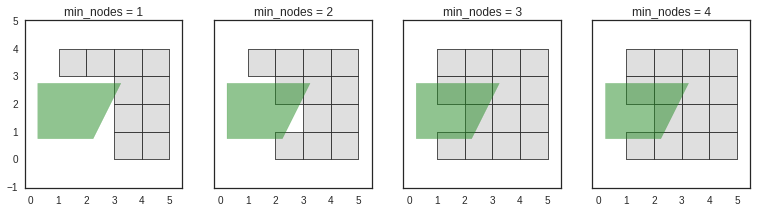

In [4]:
fig, axes = plt.subplots(figsize=(13, 3),ncols=4, sharex=True, sharey=True)


common_opts = dict(use_centroids=False, use_existing=False, inside=True)

for min_nodes, ax in enumerate(axes.flat, 1):
    # mask inside
    mg.mask_cells_with_polygon(rectangle_coords, min_nodes=min_nodes, **common_opts)
    rect = plt.Polygon(rectangle_coords, color='forestgreen', alpha=0.5)
    mg.plotCells(ax=ax)
    ax.add_patch(rect)
    ax.set_title("min_nodes = {:d}".format(min_nodes))


## Load a grid boundary, river, and set of islands using `pygridtools.io`

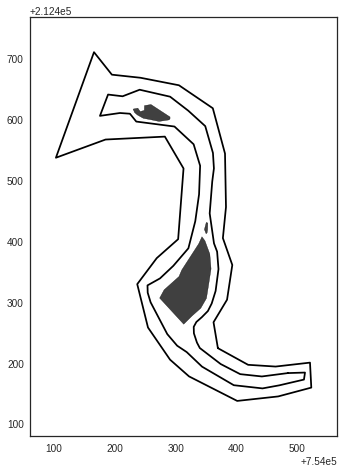

In [5]:
boundaryfile = "masking_data/input/GridBoundary.shp"
gridbounds = pgt.iotools.loadBoundaryFromShapefile(
    boundaryfile, 
    sortcol='sort_order', 
    upperleftcol='upper_left'
)

riverfile = "masking_data/input/River.shp"
river = pgt.iotools.loadPolygonFromShapefile(riverfile)

islandfile = "masking_data/input/Islands.shp"
island_arrays = pgt.iotools.loadPolygonFromShapefile(islandfile)
island_df = pandas.concat([
    pandas.DataFrame({'x': arr[:, 0], 'y': arr[:, 1], 'name': n})
    for n, arr in enumerate(island_arrays)
])


fig, ax = plt.subplots(figsize=(7.5, 7.5), subplot_kw={'aspect': 'equal'})
fig = pgt.viz.plotDomain(data=gridbounds, domain_x='x', domain_y='y', ax=ax)
fig = pgt.viz.plotBoundaries(ax=ax, engine='mpl', extent_x=river[:, 0], extent_y=river[:, 1],
                             islands=island_df, islands_x='x', islands_y='y', islands_name='name')

## Create a `Gridgen` object and convert to a `ModelGrid`

In [6]:
# number of nodes in each dimension
nx = 100
ny = 20

# grid focus
focus = pgg.Focus()

# tighten the grid in the channels around the big island
focus.add_focus_y(5./ny, 4., Ry=8./ny)
focus.add_focus_y(14.5/ny, 4., Ry=4./ny)

# coarsen the grid upstream
focus.add_focus_x(98./nx, 0.25, Rx=4./nx)

# tighten the grid around the big island's bend
focus.add_focus_x(52./nx, 4., Rx=20./nx)

# generate the main grid
grid = pgt.makeGrid(
    domain=gridbounds, 
    nx=nx, 
    ny=ny,
    focus=focus,
    rawgrid=False
)


## Show the raw (unmasked) grid

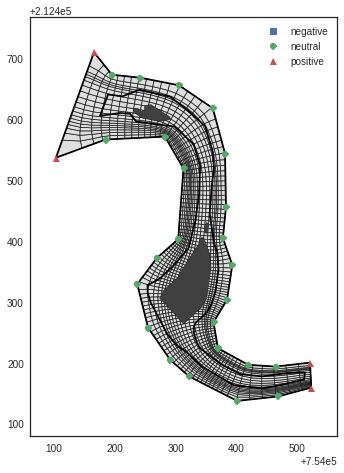

In [7]:
grid.domain = gridbounds
grid.extent = pandas.DataFrame(river, columns=['x', 'y'])
grid.islands = island_df

fig, ax = plt.subplots(figsize=(7.5, 7.5))
fig = grid.plotCells(
    ax=ax, 
    domain_kws=dict(domain_x='x', domain_y='y', beta='beta'),
    extent_kws=dict(extent_x='x', extent_y='y'),
    island_kws=dict(islands_x='x', islands_y='y', islands_name='name')
)

## Mask out everything beyond the river banks

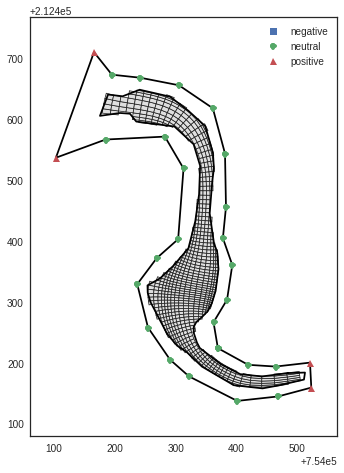

In [8]:
# outside the banks
grid.mask_cells_with_polygon(river, inside=False)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
fig = grid.plotCells(
    ax=ax, 
    domain_kws=dict(domain_x='x', domain_y='y', beta='beta'),
    extent_kws=dict(extent_x='x', extent_y='y'),
)
ax.grid(False)
ax.set_aspect('equal')

## Loop through and mask out the islands

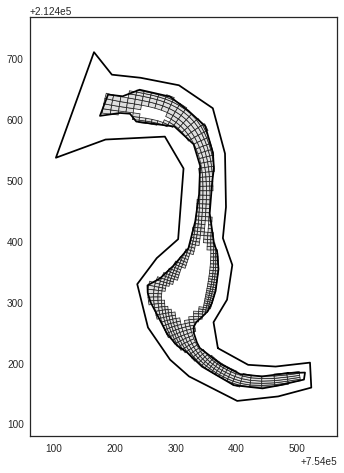

In [9]:
# inside the multiple islands
for island in island_arrays:
    grid.mask_cells_with_polygon(island, inside=True)
    
fig, ax = plt.subplots(figsize=(7.5, 7.5))
fig = grid.plotCells(
    ax=ax, 
    domain_kws=dict(domain_x='x', domain_y='y'),
    extent_kws=dict(extent_x='x', extent_y='y'),
)


## Export the masked cells to a shapefile

In [10]:
template = 'masking_data/input/cell_template.shp'
grid.to_shapefile('masking_data/output/ModelCells.shp', usemask=True, 
                  which='grid', geom='Polygon', 
                  template=template)

## View the final input and output in the QGIS file in `examples/masking_data/Grid.qgs`